In [6]:
# ==========================================
# CONFIGURAZIONE E IMPORT
# ==========================================
import os
import sys

# =============================================================================
# 1. ENVIRONMENT SANITIZATION (Reset)
# =============================================================================
# We force a return to the container root and wipe the existing repository.
# This prevents "State Leakage" where old config files or artifacts from a
# previous run might corrupt the current execution.
print(">>> Executing Environment Reset (Clean Slate)...")
try:
    os.chdir('/content/')
    # Force remove (-rf) to handle non-empty directories and git history without prompts
    !rm -rf Hawk-AI-CV-Project
except Exception as e:
    # Pass silently if directory doesn't exist (first run)
    pass

# =============================================================================
# 2. SOURCE CODE RETRIEVAL (Clone)
# =============================================================================
# Pulling the latest version of the codebase (HEAD) from the remote origin.
!git clone https://github.com/leonardoCosta02/Hawk-AI-CV-Project.git

# =============================================================================
# 3. RUNTIME CONTEXT & PATH CONFIGURATION
# =============================================================================
repo_name = "Hawk-AI-CV-Project"

# Change the working directory of the shell/notebook kernel to the project root.
%cd $repo_name

# CRITICAL: UPDATING PYTHONPATH
# By default, Python looks for modules in site-packages and the script directory.
# We explicitly inject the current working directory (os.getcwd()) to the TOP (index 0)
# of sys.path.
# WHY? This allows us to use absolute imports like `from src import config`
# regardless of which sub-folder we are currently executing code in.
sys.path.insert(0, os.getcwd())

# =============================================================================
# 4. DEPENDENCY RESOLUTION
# =============================================================================
print(">>> Installing Runtime Dependencies...")
# - numpy: Vector math
# - opencv-python: Computer Vision algorithms (Canny, Hough, Homography)
# - matplotlib: Visualization and plotting
!pip install numpy opencv-python matplotlib

# =============================================================================
# 5. VERIFICATION
# =============================================================================
print("\n>>> Setup Complete. Active Runtime Root:")
print(os.getcwd())
# Check if imports work immediately to fail fast if something went wrong
try:
    import numpy as np
    import cv2
    print(f">>> Dependencies verified: OpenCV {cv2.__version__}")
except ImportError as e:
    print(f"!!! CRITICAL ERROR: Dependency installation failed - {e}")

>>> Executing Environment Reset (Clean Slate)...
Cloning into 'Hawk-AI-CV-Project'...
remote: Enumerating objects: 783, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 783 (delta 1), reused 0 (delta 0), pack-reused 775 (from 2)
Receiving objects: 100% (783/783), 58.66 MiB | 31.03 MiB/s, done.
Resolving deltas: 100% (331/331), done.
/content/Hawk-AI-CV-Project
>>> Installing Runtime Dependencies...

>>> Setup Complete. Active Runtime Root:
/content/Hawk-AI-CV-Project
>>> Dependencies verified: OpenCV 4.12.0


In [25]:
# ==========================================
# CELLA 1: CONFIGURAZIONE E IMPORT
# ==========================================
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import csv
import os
from google.colab import files

print("Librerie importate. Pronto per il giudizio.")

COURT_DIMENSIONS = {
    # Limiti in Metri (Sistema di riferimento M3)
    'X_MIN': -0.10,   # Margine di tolleranza linea sinistra
    'X_MAX': 8.33,    # 8.23m (larghezza singolare) + 10cm tolleranza
    'Y_MIN': -5.59,   # -5.49m (distanza servizio-fondo) - 10cm tolleranza
    'Y_MAX': 6.50     # 6.40m (distanza servizio-rete) + 10cm tolleranza
}

def is_point_in(x, y):
    """Restituisce True se il punto (metri) è dentro le righe."""
    in_x = COURT_DIMENSIONS['X_MIN'] <= x <= COURT_DIMENSIONS['X_MAX']
    in_y = COURT_DIMENSIONS['Y_MIN'] <= y <= COURT_DIMENSIONS['Y_MAX']
    return in_x and in_y

Librerie importate. Pronto per il giudizio.


In [29]:
# ==========================================
# CELLA 2: CLASSE GIUDICE (LOGICA IN/OUT POTENZIATA)
# ==========================================
import cv2 as cv
import numpy as np

if 'COURT_DIMENSIONS' not in globals():
    COURT_DIMENSIONS = {
        'X_MIN': -0.10, 'X_MAX': 8.33,
        'Y_MIN': -5.59, 'Y_MAX': 6.50
    }

def is_point_in(x, y):
    # Funzione helper per verificare se X,Y sono nel rettangolo
    return (COURT_DIMENSIONS['X_MIN'] <= x <= COURT_DIMENSIONS['X_MAX'] and
            COURT_DIMENSIONS['Y_MIN'] <= y <= COURT_DIMENSIONS['Y_MAX'])

class HawkEyeJudge:
    def __init__(self, homography_matrix):
        self.H = homography_matrix

    def pixel_to_world(self, u, v):
        """Converte coordinate pixel (u,v) in metri (X,Y) usando H."""
        point_vec = np.array([u, v, 1.0])
        mapped_vec = np.dot(self.H, point_vec)

        if mapped_vec[2] != 0:
            x_world = mapped_vec[0] / mapped_vec[2]
            y_world = mapped_vec[1] / mapped_vec[2]
            return x_world, y_world
        return None, None

    def detect_bounces(self, trajectory):
        """
        Analizza la traiettoria verticale (Y pixel) con filtri anti-rumore.
        """
        bounces = []

        if len(trajectory) < 10:
            return bounces

        last_bounce_frame = -999 # Per il filtro temporale

        # Analizziamo la curva
        for t in range(2, len(trajectory) - 2):
            pt_curr = trajectory[t]

            # Recuperiamo i vicini
            neighbors = [trajectory[t-2], trajectory[t-1], trajectory[t], trajectory[t+1], trajectory[t+2]]

            # Se manca qualche dato nel range, saltiamo
            if any(p is None for p in neighbors):
                continue

            y_curr = pt_curr[1]
            y_prev = neighbors[1][1]
            y_next = neighbors[3][1]
            y_prev2 = neighbors[0][1]
            y_next2 = neighbors[4][1]

            # 1. IDENTIFICAZIONE PICCO (Massimo locale in Y pixel = Punto più basso visivo)
            is_local_max = (y_curr > y_prev and y_curr > y_next and
                            y_curr >= y_prev2 and y_curr >= y_next2)

            if is_local_max:
                # 2. FILTRO AMPIEZZA (Noise Threshold)
                # Calcola quanto è "profondo" questo rimbalzo rispetto ai vicini
                diff_prev = y_curr - y_prev2
                diff_next = y_curr - y_next2

                # Aumentato da 2 a 5 pixel per evitare falsi positivi da vibrazione
                if diff_prev > 5 and diff_next > 5:

                    # 3. FILTRO TEMPORALE (Time Debounce)
                    # Ignora rimbalzi se ne abbiamo appena segnato uno 10 frame fa
                    if (t - last_bounce_frame) > 10:
                        bounces.append({
                            'frame': t,
                            'pixel': pt_curr
                        })
                        last_bounce_frame = t # Aggiorna l'ultimo rimbalzo visto

        return bounces

    def adjudicate_video(self, video_path, trajectory, output_path):
        """Disegna il video finale con la decisione."""
        cap = cv.VideoCapture(video_path)
        if not cap.isOpened():
            print(f"Errore apertura video: {video_path}")
            return

        fps = cap.get(cv.CAP_PROP_FPS)
        width = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))

        fourcc = cv.VideoWriter_fourcc(*'mp4v')
        out = cv.VideoWriter(output_path, fourcc, fps, (width, height))

        # 1. Trova i rimbalzi (con la nuova logica filtrata)
        bounces = self.detect_bounces(trajectory)
        print(f"🎾 Rimbalzi confermati dopo il filtraggio: {len(bounces)}")

        # Dizionario decisioni
        decisions = {}
        for b in bounces:
            frame_idx = b['frame']
            px, py = b['pixel']

            wx, wy = self.pixel_to_world(px, py)

            if wx is not None:
                verdict = "IN" if is_point_in(wx, wy) else "OUT"
                color = (0, 255, 0) if verdict == "IN" else (0, 0, 255)

                decisions[frame_idx] = {
                    'verdict': verdict,
                    'coords': (wx, wy),
                    'color': color
                }
                print(f"   -> Frame {frame_idx}: {verdict} (X={wx:.2f}m, Y={wy:.2f}m)")

        # Variabili display
        current_display = None
        display_timer = 0
        DISPLAY_DURATION = int(fps * 2)

        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            # A. Logica Trigger Scritta (range +/- 1 frame)
            for offset in [-1, 0, 1]:
                if (frame_count + offset) in decisions:
                    current_display = decisions[frame_count + offset]
                    display_timer = DISPLAY_DURATION
                    break

            # B. Disegna Pallino Palla
            if frame_count < len(trajectory) and trajectory[frame_count] is not None:
                cx, cy = int(trajectory[frame_count][0]), int(trajectory[frame_count][1])
                cv.circle(frame, (cx, cy), 5, (0, 255, 255), -1)

            # C. Disegna Overlay Decisione
            if display_timer > 0 and current_display:
                verdict = current_display['verdict']
                color = current_display['color']
                wx, wy = current_display['coords']

                # Box scuro per contrasto
                cv.rectangle(frame, (50, 150), (450, 320), (0,0,0), -1)

                # Testo
                cv.putText(frame, verdict, (80, 240), cv.FONT_HERSHEY_SIMPLEX,
                           3, color, 8, cv.LINE_AA)
                cv.putText(frame, f"X: {wx:.2f} m", (80, 280),
                           cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 1)
                cv.putText(frame, f"Y: {wy:.2f} m", (80, 310),
                           cv.FONT_HERSHEY_SIMPLEX, 0.8, (255, 255, 255), 1)

                display_timer -= 1

            out.write(frame)
            frame_count += 1

        cap.release()
        out.release()
        print(f"✅ Video salvato: {output_path}")

In [36]:
# ==========================================
# CELLA 3: ESECUZIONE DEL GIUDICE (Versione Robusta)
# ==========================================
import pandas as pd
import numpy as np # Importante per la matrice
import glob
import os
from google.colab import files

# 1. LA TUA MATRICE H
# DA SOSTITUIRE (!!)
# -----------------------------------------------------------
H_MATRIX = np.array([
    [ 6.60767767e-02,  2.68232422e-02, -3.15310509e+01],
    [-4.44622299e-04, -2.13413995e-01,  1.07256989e+02],
    [ 1.94201000e-05,  6.47891119e-03,  1.00000000e+00]
])
# -----------------------------------------------------------

print("Inizializzazione Giudice...")
try:
    judge = HawkEyeJudge(H_MATRIX)
except NameError:
    print("ERRORE: Inizializzare class HawkEyeJudge !")
    judge = None

if judge:
    # Cerchiamo i file CSV che iniziano con DATI_
    csv_files = glob.glob("DATI_*.csv")

    if not csv_files:
        print("Nessun file 'DATI_*.csv' contenente le coordinate trovato nella cartella corrente.")
    else:
        print(f"Trovati {len(csv_files)} file dati da analizzare.")

        for csv_path in csv_files:
            print(f"\n" + "="*40)
            print(f"🔎 Analisi file dati: {csv_path}")

            # A. Ricostruisci il nome del video originale
            # 1. Prendi solo il nome file (es. DATI_video1.csv) ignorando cartelle
            nome_file_pulito = os.path.basename(csv_path)

            # 2. Rimuovi il prefisso "DATI_" e il suffisso ".csv"
            nome_base = nome_file_pulito.replace("DATI_", "").replace(".csv", "")

            print(f"Cerco il video corrispondente a: '{nome_base}'")

            # 3. Cerca il video in varie posizioni possibili (da modificare !!)
            possibili_path = [
                os.path.join(os.getcwd(), 'data', 'videos'), # Cartella strutturata
                os.getcwd(),                                 # Cartella corrente (/content)
                '/content'                                   # Root esplicita
            ]

            video_path = None
            estensioni = ['.mp4', '.mov', '.avi']

            for cartella in possibili_path:
                for ext in estensioni:
                    test_path = os.path.join(cartella, nome_base + ext)
                    if os.path.exists(test_path):
                        video_path = test_path
                        break
                if video_path: break

            if not video_path:
                print(f"VIDEO NON TROVATO!")
                continue

            print(f"Video trovato: {video_path}")

            try:
                df = pd.read_csv(csv_path)

                # Trova il frame massimo
                max_frame = int(df['frame'].max())

                # Crea lista (aggiungo +50 di buffer per sicurezza)
                trajectory_list = [None] * (max_frame + 50)

                # Riempi la lista
                punti_validi = 0
                for _, row in df.iterrows():
                    try:
                        idx = int(row['frame'])
                        u, v = float(row['u']), float(row['v'])

                        # Controllo base per evitare valori assurdi
                        if not np.isnan(u) and not np.isnan(v):
                            trajectory_list[idx] = (u, v)
                            punti_validi += 1
                    except ValueError:
                        continue # Salta righe corrotte

                print(f"Caricati {punti_validi} punti di tracciamento.")

                # C. Esegui il giudizio
                output_filename = f"JUDGED_{nome_base}.mp4"

                judge.adjudicate_video(video_path, trajectory_list, output_filename)

                # D. Scarica
                if os.path.exists(output_filename):
                    print(f"   💾 Download in corso: {output_filename}")
                    files.download(output_filename)
                else:
                    print("Errore: Il video output non è stato creato.")

            except Exception as e:
                print(f"Errore durante l'elaborazione di {nome_base}: {e}")

Inizializzazione Giudice...
Trovati 1 file dati da analizzare.

🔎 Analisi file dati: DATI_video2.csv
Cerco il video corrispondente a: 'video2'
Video trovato: /content/Hawk-AI-CV-Project/data/videos/video2.mov
Caricati 157 punti di tracciamento.
🎾 Rimbalzi confermati dopo il filtraggio: 6
   -> Frame 24: OUT (X=12.55m, Y=-17.91m)
   -> Frame 79: OUT (X=15.17m, Y=-17.87m)
   -> Frame 93: OUT (X=22.08m, Y=-6.83m)
   -> Frame 111: OUT (X=9.14m, Y=-21.30m)
   -> Frame 133: OUT (X=12.10m, Y=-13.53m)
   -> Frame 144: OUT (X=11.74m, Y=-12.04m)
✅ Video salvato: JUDGED_video2.mp4
   💾 Download in corso: JUDGED_video2.mp4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Testing su: JUDGED_video1.mp4


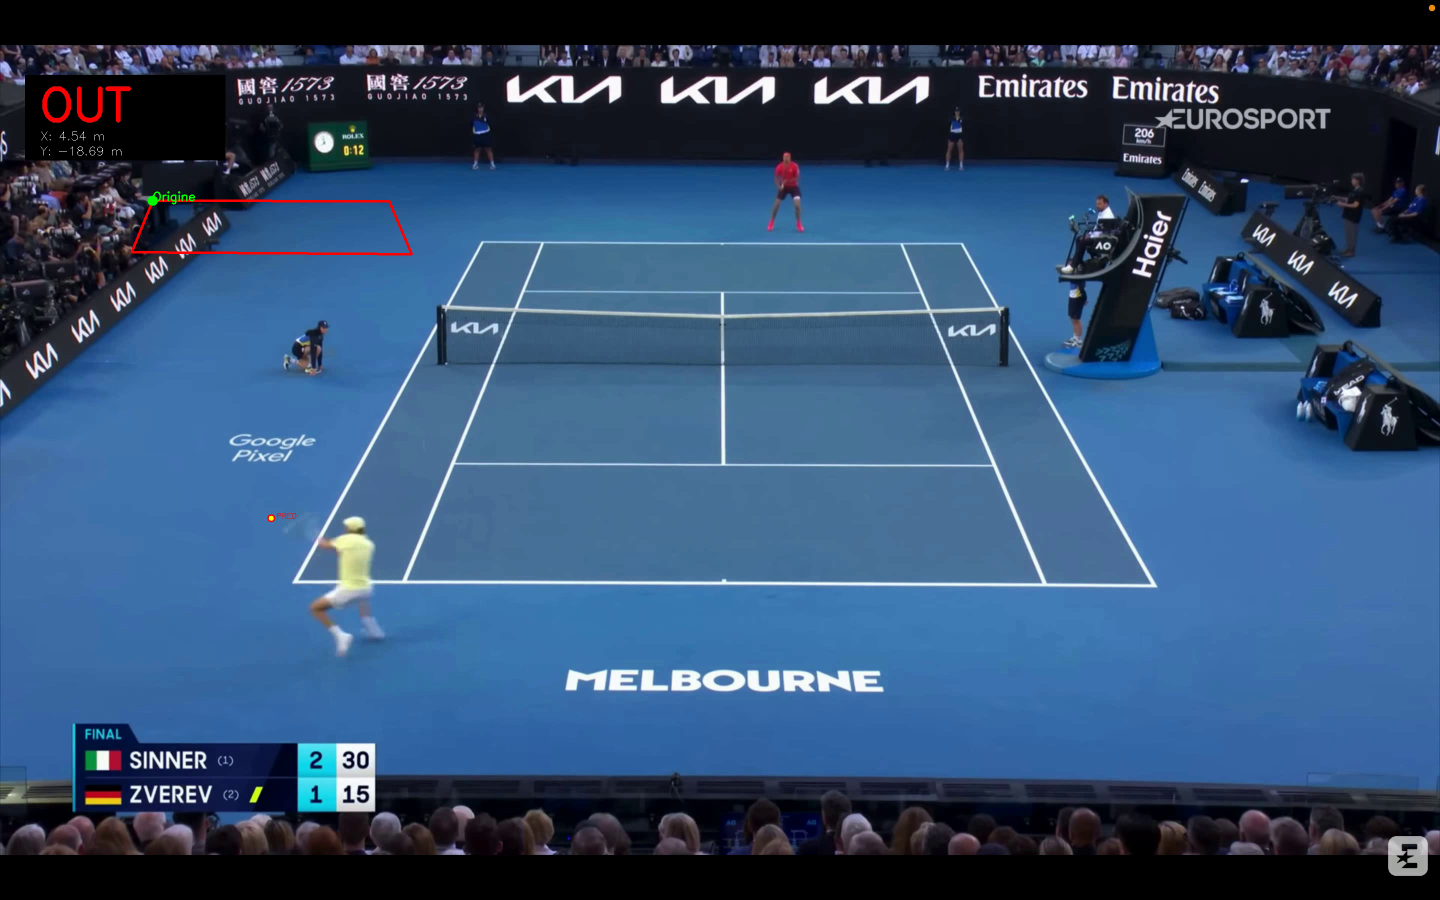

In [35]:
# ==========================================
# CELLA DI DEBUG: VISUALIZZA LA GRIGLIA
# ==========================================
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# 1. La tua matrice H attuale
H_MATRIX = np.array([
    [ 6.50980565e-02,  2.65116930e-02, -3.04981716e+01],
    [ 4.50826453e-04, -2.30370522e-01,  9.22956276e+01],
    [ 1.76143090e-04,  6.49680276e-03,  1.00000000e+00]
])

# 2. Definiamo i 4 angoli del campo (in METRI) secondo il sistema M3
# Ordine: [0,0] (Servizio SX), [8.23, 0] (Servizio DX), [8.23, 6.40] (Rete DX), [0, 6.40] (Rete SX)
# Usiamo i punti chiave delle righe del singolare
punti_metri = np.array([
    [0.0,  0.0],   # Intersezione T servizio / laterale sinistra
    [8.23, 0.0],   # Intersezione T servizio / laterale destra
    [8.23, 6.40],  # Rete / laterale destra
    [0.0,  6.40],  # Rete / laterale sinistra
    [0.0, -5.49],  # Fondo / laterale sinistra
    [8.23, -5.49]  # Fondo / laterale destra
], dtype='float32')

def disegna_campo_su_frame(frame, H):
    # Calcoliamo l'inversa per proiettare Metri -> Pixel
    try:
        H_inv = np.linalg.inv(H)
    except:
        print("La matrice non è invertibile!")
        return frame

    # Convertiamo i punti metri in coordinate omogenee [x, y, 1]
    h, w = frame.shape[:2]
    pts_pixel = []

    for pm in punti_metri:
        vec_m = np.array([pm[0], pm[1], 1])
        vec_px = np.dot(H_inv, vec_m)

        # Normalizza
        if vec_px[2] != 0:
            u = int(vec_px[0] / vec_px[2])
            v = int(vec_px[1] / vec_px[2])
            pts_pixel.append((u, v))

            # Disegna punto
            cv.circle(frame, (u, v), 10, (0, 0, 255), -1)
            cv.putText(frame, f"{pm[0]},{pm[1]}", (u+10, v), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 2)

    return frame

# --- TEST SU UN FRAME A CASO DEL TUO VIDEO ---
video_path = "JUDGED_video1.mp4" # <--- CONTROLLA NOME FILE
cap = cv.VideoCapture(video_path)
ret, frame = cap.read()
if ret:
    frame_debug = disegna_campo_su_frame(frame, H_MATRIX)
    cv2_imshow(frame_debug)
else:
    print("Impossibile leggere il video per il debug.")
cap.release()